# Graph structure phase diagram
Phase diagram with number of edges and centralisation, all other parameters fixed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))

from classes.world import World
from classes.agent import Agent

Function that builds the agents and graph.

In [2]:
def build_agents_amd_graph(num_agents=5, share_threshold=0.5, truth_weight=0.5, number_of_additional_edges=5, centralisation=0.5, weigth_option1=False):

    #make sure number_of_additional_edges edges can be added to the graph
    assert 2 * num_agents + number_of_additional_edges <= num_agents*(num_agents - 1), 'not possible'

    # Agents
    agents = []
    for i in range(num_agents):
        agents.append(Agent(str(i), share_threshold, truth_weight))

    # Graph
    graph = nx.DiGraph()
    graph.add_nodes_from(agents)

    # Connect agents in a Circle in both directions so graph is connected
    if num_agents > 1:
        graph.add_edge(agents[0], agents[-1])
        graph.add_edge(agents[-1], agents[0])
        if num_agents > 2:
            for i in range(num_agents - 1):
                graph.add_edge(agents[i], agents[i + 1])
                graph.add_edge(agents[i + 1], agents[i])

    # Add additional edges according to centralisation
    current_information_provider = None
    for n in range(number_of_additional_edges):
        if n==0:
            # Choose provider and receiver randomly
            current_information_provider = np.random.choice(agents)
            information_receiver = np.random.choice([a for a in agents if (a != current_information_provider and (not graph.has_edge(current_information_provider, a)))])
            graph.add_edge(current_information_provider, information_receiver)
        else:
            # Change provider with Probability 1 - centralisation
            if np.random.random() > centralisation:
                current_information_provider = np.random.choice([a for a in agents if a != current_information_provider])
            # Make sure receiver can be selected
            while len([a for a in agents if (a != current_information_provider and (not graph.has_edge(current_information_provider, a)))]) == 0:
                current_information_provider = np.random.choice([a for a in agents if a != current_information_provider])
            information_receiver = np.random.choice([a for a in agents if (a != current_information_provider and (not graph.has_edge(current_information_provider, a)))])
            graph.add_edge(current_information_provider, information_receiver)

    # Set weights on edges
    if weigth_option1:
        # Option 1:
        for node in graph.nodes():
            in_degree = graph.in_degree[node]
            for edge in graph.in_edges(node):
                graph.edges[edge]['weight'] = 1 / in_degree
    else:
        # Option 2:
        # Put out_degree as weight
        for node in graph.nodes():
            # Set out-degree as weight on out-going edges
            out_degree = graph.out_degree[node]
            for edge in graph.edges(node):
                graph.edges[edge]['weight'] = out_degree

        # Normalize over in-going edges
        for node in graph.nodes():
            sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))
            for edge in graph.in_edges(node):
                graph.edges[edge]['weight'] /= sum_ingoing

    return agents, graph

Define function which generates a matrix with percentages of how many agents shared the news for different values of `number_of_additional_edges` and `centralisation`.

In [3]:
def generate_share_map(num_bins=51, factor=10, num_agents=100, num_updates=20, news_fitness=1.0, share_threshold=0.5, truth_weight=0.5, graph_samples=10, weigth_option1=False):
    numbers_of_additional_edges = np.arange(num_bins) * factor
    centralisation_values = np.linspace(0, 1, num_bins)

    df = pd.DataFrame(columns=['additional edges', 'centralisation', 'number shared'])

    print(f'Starting simulation with {num_agents} agents (this may take some time...)')
    for number_of_additional_edges in numbers_of_additional_edges:
        for centralisation in centralisation_values:
            number_samples = []
            for g_nmb in range(graph_samples):
                agents, graph = build_agents_amd_graph(num_agents=num_agents, share_threshold=share_threshold,
                                                       truth_weight=truth_weight, number_of_additional_edges=number_of_additional_edges,
                                                       centralisation=centralisation, weigth_option1=weigth_option1)

                world = World(num_agents=num_agents, agents=agents, graph=graph, news_fitness=news_fitness)
                world.update(time_steps=num_updates)

                number_samples.append(world.get_number_active_agents())

            num_sharing = pd.DataFrame([[number_of_additional_edges, centralisation, np.mean(number_samples) / num_agents]], columns=df.columns)
            df = df.append(num_sharing, ignore_index=True)

    print('Simulation completed!!!')

    return df.astype(float).pivot('additional edges', 'centralisation', 'number shared')

### Share Maps

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-756ce2aa7fda>:60: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

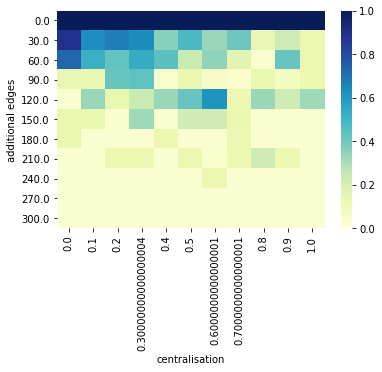

In [4]:
share_map = generate_share_map(num_agents= 30, num_bins=11, factor=30, news_fitness=0.95, share_threshold=0.6, truth_weight=0.5)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-756ce2aa7fda>:60: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

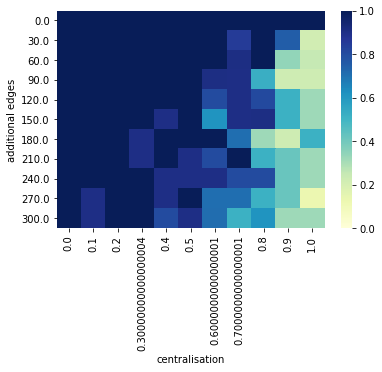

In [5]:
share_map = generate_share_map(num_agents= 30, num_bins=11, factor=30, news_fitness=0.95, share_threshold=0.5, truth_weight=0.5)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-756ce2aa7fda>:60: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

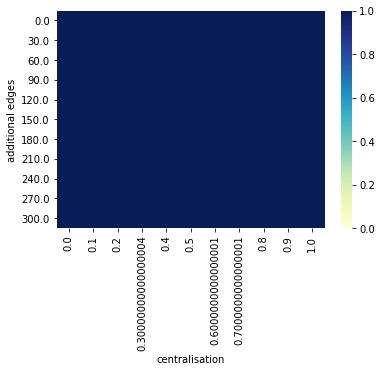

In [6]:
share_map = generate_share_map(num_agents= 30, num_bins=11, factor=30, news_fitness=0.95, share_threshold=0.4, truth_weight=0.5)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

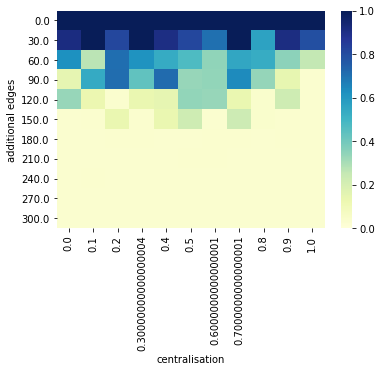

In [7]:
share_map = generate_share_map(num_agents= 30, num_bins=11, factor=30, news_fitness=0.95, share_threshold=0.6, truth_weight=0.5, weigth_option1=True)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

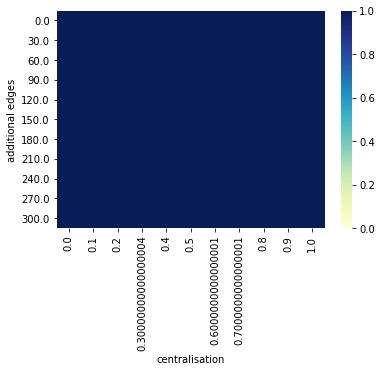

In [8]:
share_map = generate_share_map(num_agents= 30, num_bins=11, factor=30, news_fitness=0.95, share_threshold=0.5, truth_weight=0.5, weigth_option1=True)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

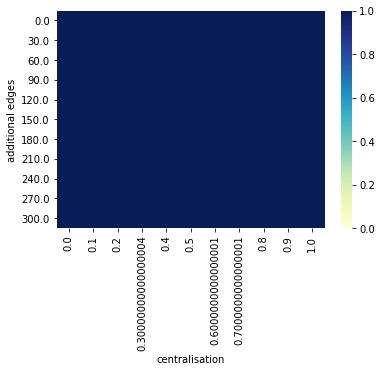

In [9]:
share_map = generate_share_map(num_agents= 30, num_bins=11, factor=30, news_fitness=0.95, share_threshold=0.4, truth_weight=0.5, weigth_option1=True)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)